In [1]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMG_DIM = (400, 400) 
BATCH = 32

#Seed for reproducability
SEED = 37
tf.random.set_seed(SEED)
np.random.seed(SEED)

data_dir = 'Dataset/'

#Varying rotation and brightness for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    brightness_range=[0.8, 1.2], 
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_DIM,
    batch_size=BATCH,
    subset="training",
    class_mode='categorical',
    seed=SEED,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_DIM,
    batch_size=BATCH,
    subset="validation",
    class_mode='categorical',
    seed=SEED,
    shuffle=True
)

#Different seed for different samples for testing
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_DIM,
    batch_size=BATCH,
    subset="validation",
    class_mode='categorical',
    seed=42,
    shuffle=True
)

# Save the best model checkpoint
checkpoint = ModelCheckpoint(
    filepath='mobilenet_best.weights.h5',
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=True
)

mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(400, 400, 3))

# Freeze base model initially
mobilenet.trainable = False

model = Sequential([
    mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),  # Stabilizes training
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Dropout for better generalization
    layers.Dense(17, activation='softmax')
])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Model trained for 50 epochs
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

# Unfreeze last few layers for Fine-Tuning
mobilenet.trainable = True
# Freeze all layers except last 20
for layer in mobilenet.layers[:-20]:  
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-Tuning
history_fine = model.fit(
    train_generator,
    epochs=50, 
    validation_data=val_generator,
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

# Save training history for later use
with open('MobileNet_history.pkl', 'wb') as f:
    pickle.dump(history.history_fine, f)

# Load Best Weights
model.load_weights('mobilenet_best.weights.h5')

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the Final Model
model.save('mobilenetv2_finetuned_model.h5')


Found 6800 images belonging to 17 classes.
Found 850 images belonging to 17 classes.
Found 850 images belonging to 17 classes.


C:\Users\viole\AppData\Local\Temp\ipykernel_137424\311504568.py:67: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(400, 400, 3))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 13, 13, 1280)        │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17)                  │           2,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,429,265 (9.27 MB)

 Trainable params: 168,721 (659.07 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

C:\Users\viole\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3510 - loss: 2.3018

C:\Users\viole\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


213/213 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.3515 - loss: 2.2995 - val_accuracy: 0.4800 - val_loss: 1.6007 - learning_rate: 0.0010
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.6150 - loss: 1.1673 - val_accuracy: 0.5000 - val_loss: 1.3796 - learning_rate: 0.0010
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step - accuracy: 0.6815 - loss: 0.9261 - val_accuracy: 0.5812 - val_loss: 1.2125 - learning_rate: 0.0010
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.7244 - loss: 0.7994 - val_accuracy: 0.6059 - val_loss: 1.1779 - learning_rate: 0.0010
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.7357 - loss: 0.7350 - val_accuracy: 0.6106 - val_loss: 1.1681 - learning_rate: 0.0010
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.7469 - loss: 0.6858 - val_accuracy: 0.6424 - val_loss: 1.0609 - learning_rate: 0.0010
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.7687 - loss: 0.6529 - val_

Test Accuracy: 0.86


In [3]:
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 612ms/step - accuracy: 0.8532 - loss: 0.6032
Test Accuracy: 0.86


In [7]:
#Checking order of class labels 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
data_dir = 'Dataset/'
IMG_DIM = (400, 400)  # Change to 224x224 (MobileNetV2 default)
BATCH = 32

SEED = 37
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_DIM,
    batch_size=BATCH,
    subset="validation",
    class_mode='categorical',
    seed=42,
    shuffle=True
)

print(test_generator.class_indices)

Found 850 images belonging to 17 classes.
{'100': 0, '110': 1, '120': 2, '15': 3, '20': 4, '30': 5, '40': 6, '5': 7, '50': 8, '60': 9, '70': 10, '80': 11, '90': 12, 'CrossWalk': 13, 'Left': 14, 'Right': 15, 'Stop': 16}


Found 850 images belonging to 17 classes.


C:\Users\viole\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8732 - loss: 0.5903
Test Accuracy: 0.86
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━

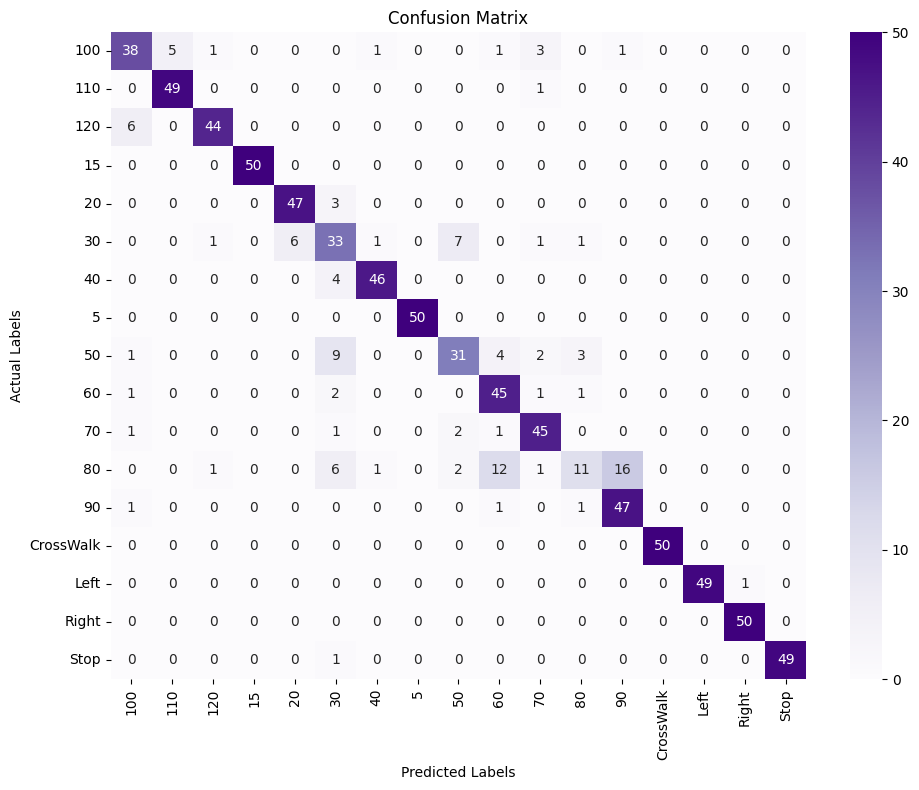

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


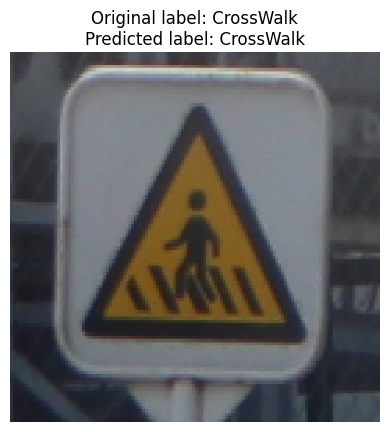

In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import load_model
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
data_dir = 'Dataset/'
IMG_DIM = (400, 400)  # Change to 224x224 (MobileNetV2 default)
BATCH = 32
SEED = 37
random.seed(SEED)
np.random.seed(SEED)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_DIM,
    batch_size=BATCH,
    subset="validation",
    class_mode='categorical',
    seed=42,
    shuffle=True
)

# Load Best Weights
model = load_model('mobilenetv2_finetuned_model.h5')

# Load class labels from the generator
class_labels = list(test_generator.class_indices.keys())

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

all_actual = []
all_predictions = []

# Iterate through test data
for test_img, test_lbl in test_generator:
    # Predict the labels for the batch
    predictions = model.predict(test_img)
    predictions = np.argmax(predictions, axis=1)  # Get predicted class indices
    test_labels = np.argmax(test_lbl, axis=1)     # Get actual class indices

    # Appends to lists
    all_actual.extend(test_labels)
    all_predictions.extend(predictions)

    # Stop after one full pass over the dataset
    if len(all_actual) >= len(test_generator.classes):
        break

accuracy = accuracy_score(all_actual, all_predictions)
print(f"Accuracy: {accuracy:.2f}")

#Calculating precision,recall and f1 scores
precision = precision_score(all_actual, all_predictions, average='macro')
recall = recall_score(all_actual, all_predictions, average='macro')
f1 = f1_score(all_actual, all_predictions, average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_actual, all_predictions, target_names=class_labels))

cm = confusion_matrix(all_actual, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.tight_layout()
plt.show()

# Check results on a few select images
n = random.randint(0, len(test_generator) - 1)  # Random index for a batch
test_img, test_lbl = test_generator[n]  # Get the specific batch

# Selects random image
imageList = list(range(test_img.shape[0]))
random.shuffle(imageList)
random_idx = random.randint(0, len(imageList) - 1)

image = test_img[random_idx]
true_labl= np.argmax(test_lbl[random_idx])

pred = model.predict(np.expand_dims(image, axis=0))
pred_labl = np.argmax(pred)

true_label = class_labels[true_labl]
pred_label = class_labels[pred_labl]

# Displays image
plt.imshow(image) 
plt.title(f"Original label: {true_label}\nPredicted label: {pred_label}")
plt.axis('off')
plt.show()

